# Bernstein-Vazirani Algorithm

In this notebook, we will implement the Bernstein-Vazirani algorithm using Qiskit. The Bernstein-Vazirani algorithm is a quantum algorithm that determines a hidden binary string with a single query, showcasing the power of quantum computing over classical methods.
We are going to follow the Medium Guide [Bernstein-Vazirani algorithm](https://medium.com/@_monitsharma/learn-quantum-computing-with-qiskit-bernstein-vazirani-algorithm-fa1300517624).

## Import Required Libraries

In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
# from qiskit import Aer # This is deprecated
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.ibmq import least_busy # This is deprecated
from qiskit_ibm_runtime import QiskitRuntimeService

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
n = 3  # number of qubits used to represent s
s = "011"  # the hidden binary string

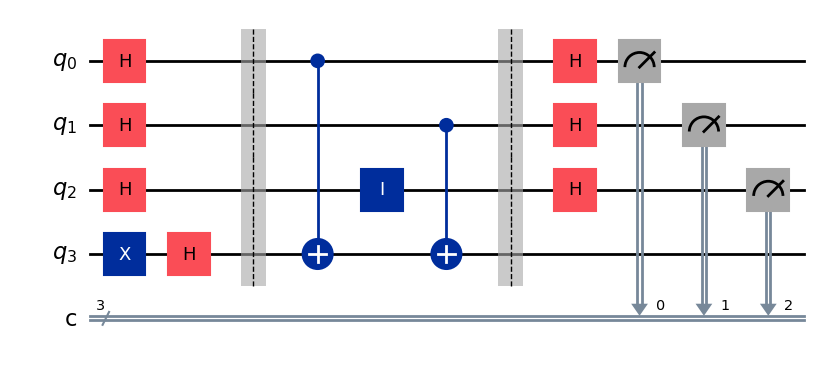

In [3]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n + 1, n)

# put auxiliary in state |->
bv_circuit.x(n)
bv_circuit.h(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Apply barrier
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1]  # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == "0":
        bv_circuit.id(q)
    else:
        bv_circuit.cx(q, n)

# Apply barrier
bv_circuit.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw("mpl")

### Using Local Simulators

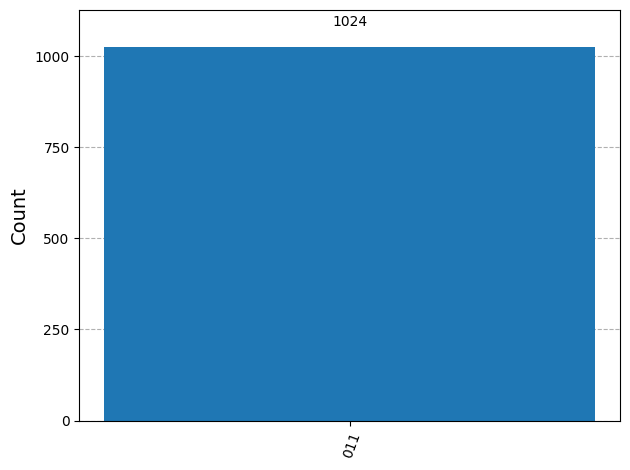

In [4]:
# Deprecated:
# aer_sim = Aer.get_backend('aer_simulator')

# use local simulator
aer_sim = AerSimulator()
bv_circuit_transpiled = transpile(bv_circuit, aer_sim)
shots = 1024
results = aer_sim.run(bv_circuit_transpiled, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

### Using Real Quantum Computers

In [5]:
# Deprecated:
# from qiskit import IBMQ

# IBMQ.save_account("ENTER API TOKEN")

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="TU_TOKEN_AQUI",
    overwrite=True,
)

In [6]:
# Deprecated code:
# # Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub="ibm-q")
# provider.backends()
# backend = least_busy(
#     provider.backends(
#         filters=lambda x: x.configuration().n_qubits <= 5
#         and x.configuration().n_qubits >= 2
#         and not x.configuration().simulator
#         and x.status().operational == True
#     )
# )
# print("least busy backend: ", backend)

service = QiskitRuntimeService(channel="ibm_quantum_platform")
candidates = service.backends(
    simulator=False, 
    operational=True, 
    filters=lambda x: 2 <= x.num_qubits <= 5
)

if not candidates:
    print("No se encontraron backends que cumplan los criterios.")
else:
    backend = min(candidates, key=lambda b: b.status().pending_jobs) # least busy backend
    
    print(f"El backend menos ocupado es: {backend.name}")
    print(f"Trabajos en cola: {backend.status().pending_jobs}")

InvalidAccountError: 'Unable to retrieve instances. Please check that you are using a valid API token.'

In [ ]:
# Deprecated code:
# # Run our circuit on the least busy backend. Monitor the execution of the job in the queue
# from qiskit.tools.monitor import job_monitor

# shots = 1024
# transpiled_bv_circuit = transpile(bv_circuit, backend)
# job = backend.run(transpiled_bv_circuit, shots=shots)

# job_monitor(job, interval=2)

from qiskit import transpile

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
job = backend.run(transpiled_bv_circuit, shots=shots)

print(f"Job enviado con ID: {job.job_id()}")

In [ ]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)